# Chronic Kidney Disease

### Aim:
To build a ML mpdel to predict Chronic Kidney Disease using electronic health records of patients with chronic kidney disease from Abu Dhabi

##### Information about this dataset
This is a dataset of electronic medical records of 491 patients collected at the Tawam Hospital in Al-Ain city (Abu Dhabi, United Arab Emirates), between 1st January and 31st December 2008. The patients included 241 women and 250 men, with an average age of 53.2 years. Each patient has a chart of 22 clinical variables, expressing her/his values of laboratory tests and exams or data about her/his medical history. Each patient included in this study had cardovascular disease or was at risk of cardiovascular disease, according to the standards of Tawam Hospital.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report
import optuna

In [2]:
data = pd.read_csv("ChronicKidneyDisease_EHRs_from_AbuDhabi.csv")

In [3]:
data.columns

Index(['Sex', 'AgeBaseline', 'HistoryDiabetes', 'HistoryCHD',
       'HistoryVascular', 'HistorySmoking', 'HistoryHTN ', 'HistoryDLD',
       'HistoryObesity', 'DLDmeds', 'DMmeds', 'HTNmeds', 'ACEIARB',
       'CholesterolBaseline', 'CreatinineBaseline', 'eGFRBaseline',
       'sBPBaseline', 'dBPBaseline', 'BMIBaseline', 'TimeToEventMonths',
       'EventCKD35', 'TIME_YEAR'],
      dtype='object')

In [4]:
x = pd.DataFrame(abs(data.corr()["EventCKD35"]))

In [5]:
data2 = data[x[x["EventCKD35"]>0.2].index.tolist()] #keeping features above 0.2 corelation

In [6]:
data2.columns

Index(['AgeBaseline', 'HistoryDiabetes', 'HistoryCHD', 'DMmeds', 'ACEIARB',
       'CreatinineBaseline', 'eGFRBaseline', 'TimeToEventMonths', 'EventCKD35',
       'TIME_YEAR'],
      dtype='object')

AgeBaseline: age of the patient    
HistoryDiabetes: if the patient had diabetes in their life  
HistoryCHD: if the patient had coronary heart disease (CHD) in their life  
DMmeds: if the patient takes diabetes medications  
ACEIARB: if the patient takes angiotensin-converting enzyme inhibitors (ACEI) or Angiotensin receptor blockers (ARB) medications  
CreatinineBaseline: creatinine level  
eGFRBaseline: estimated glomerular filtration rate (eGFR), a measure of renal function    
TimeToEventMonths: number of months from follow-up start to a severe chronic kidney disease (CKD) event or to last visit  
TIME_YEAR: year from follow-up start to a severe chronic kidney disease (CKD) event or to last visit  

##### Scaling

In [7]:
scaler = MinMaxScaler()
data2[[ 'CreatinineBaseline', 'eGFRBaseline']] = scaler.fit_transform(data2[[ 'CreatinineBaseline', 'eGFRBaseline']])

C:\Users\shasa\AppData\Local\Temp\ipykernel_31976\2728019858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[[ 'CreatinineBaseline', 'eGFRBaseline']] = scaler.fit_transform(data2[[ 'CreatinineBaseline', 'eGFRBaseline']])


#### PCA

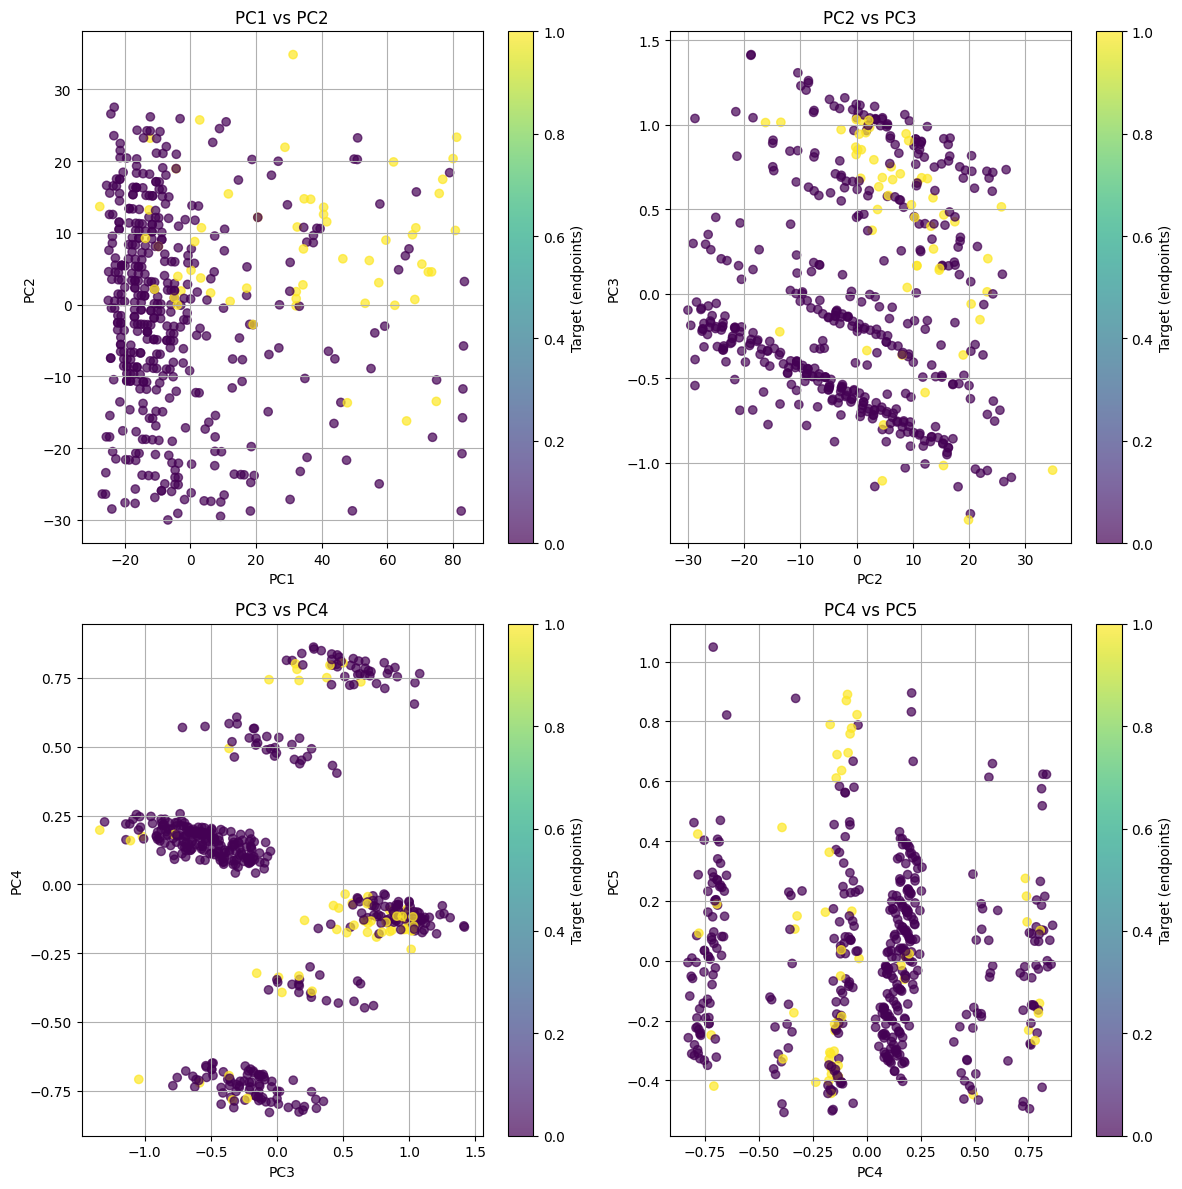

In [8]:
pca = PCA(n_components=5)
principal_components = pca.fit_transform(data2.drop("EventCKD35",axis=1))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5'])
pca_df['Target'] = data2['EventCKD35']

pairs = [('PC1', 'PC2'), ('PC2', 'PC3'), ('PC3', 'PC4'), ('PC4', 'PC5')]

plt.figure(figsize=(12, 12))
for i, (x, y) in enumerate(pairs, start=1):
    plt.subplot(2, 2, i) 
    scatter = plt.scatter(
        pca_df[x], pca_df[y], c=pca_df['Target'], cmap='viridis', alpha=0.7
    )
    plt.colorbar(scatter, label='Target (endpoints)')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs {y}')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
component_weights = pca.components_
ex_var = pca.explained_variance_
ex_ratio = pca.explained_variance_ratio_

Text(0.5, 1.0, 'Variance ratio captured by PCs')

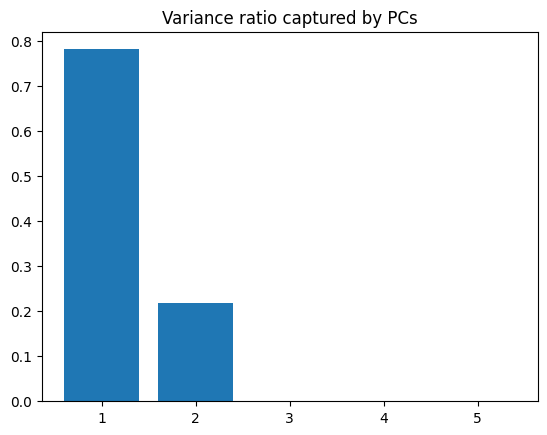

In [10]:
plt.bar(list(range(1,6)),ex_ratio)
plt.title("Variance ratio captured by PCs")

In [11]:
X = data2.drop('EventCKD35', axis=1)
y = data2['EventCKD35']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
class_report = classification_report(y_test, preds)
conf_matrix = confusion_matrix(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8918918918918919
Precision: 0.6666666666666666
Recall: 0.47619047619047616
F1 Score: 0.5555555555555556

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       127
           1       0.67      0.48      0.56        21

    accuracy                           0.89       148
   macro avg       0.79      0.72      0.75       148
weighted avg       0.88      0.89      0.88       148

Confusion Matrix:
 [[122   5]
 [ 11  10]]


In [13]:
y.value_counts()

0    435
1     56
Name: EventCKD35, dtype: int64

Class imbalance in the data, the model might not be robust enough and yet to learn better on the data which is evident from a low recal.  
Hence we follow with an over sampling method to balance the classes

In [14]:
over_sampler = RandomOverSampler(random_state=42)
X, y = over_sampler.fit_resample(X, y)

In [15]:
y.value_counts()

0    435
1    435
Name: EventCKD35, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
class_report = classification_report(y_test, preds)
conf_matrix = confusion_matrix(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9808429118773946
Precision: 0.9652777777777778
Recall: 1.0
F1 Score: 0.9823321554770318

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       122
           1       0.97      1.00      0.98       139

    accuracy                           0.98       261
   macro avg       0.98      0.98      0.98       261
weighted avg       0.98      0.98      0.98       261

Confusion Matrix:
 [[117   5]
 [  0 139]]


<BarContainer object of 9 artists>

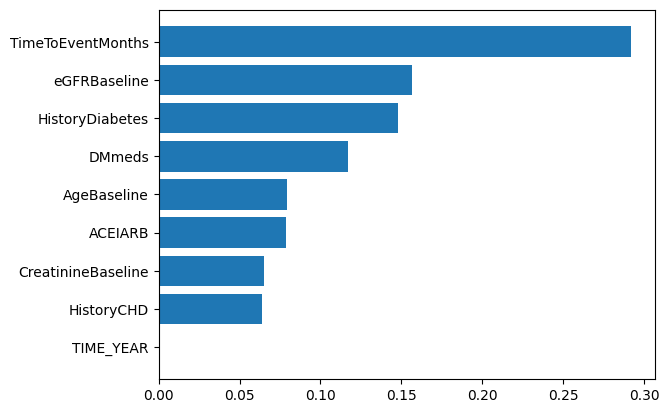

In [17]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx],xgb.feature_importances_[idx])

In [18]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
    }
    model = XGBClassifier(**param, eval_metric="logloss",enable_categorical=True)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

best_params = study.best_trial.params
best_model = XGBClassifier(**best_params, eval_metric="logloss",enable_categorical=True)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

[I 2025-01-19 18:59:04,915] A new study created in memory with name: no-name-2be92eca-5bcf-419b-84cf-afd96cf44e93
[I 2025-01-19 18:59:05,665] Trial 0 finished with value: 0.9047554531906247 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.09999999999999999, 'colsample_bytree': 0.9, 'subsample': 0.6, 'gamma': 2.3000000000000003, 'min_child_weight': 3}. Best is trial 0 with value: 0.9047554531906247.
[I 2025-01-19 18:59:06,784] Trial 1 finished with value: 0.9014767646660345 and parameters: {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.19, 'colsample_bytree': 0.5, 'subsample': 0.9, 'gamma': 3.0, 'min_child_weight': 6}. Best is trial 0 with value: 0.9047554531906247.
[I 2025-01-19 18:59:07,896] Trial 2 finished with value: 0.8916271507925755 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.23, 'colsample_bytree': 0.9, 'subsample': 0.8, 'gamma': 3.1, 'min_child_weight': 8}. Best is trial 0 with value: 0.9047554531906247.
[I 2025-01

Best trial:
  Value: 0.9507519306327057
  Params: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.14, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 0.0, 'min_child_weight': 1}
Test set accuracy: 0.9808


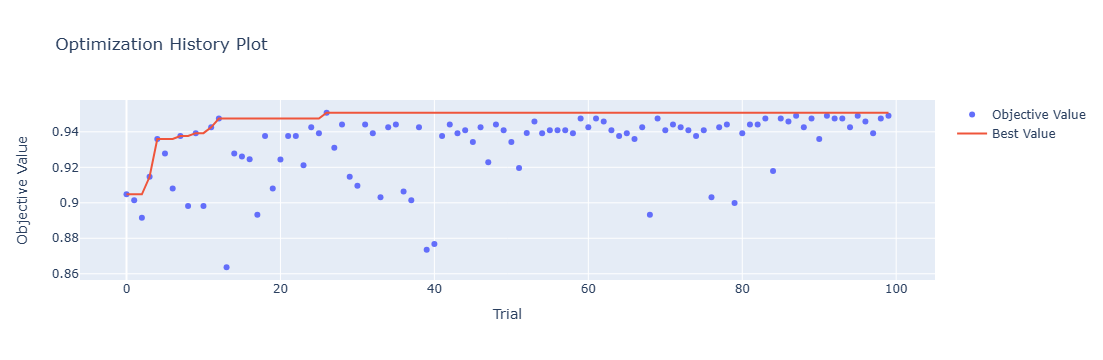

In [20]:
optuna.visualization.plot_optimization_history(study).show()

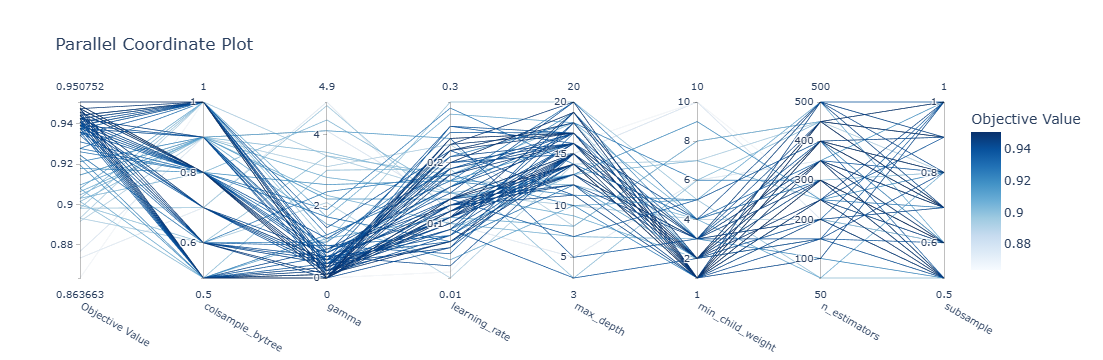

In [21]:
optuna.visualization.plot_parallel_coordinate(study).show()

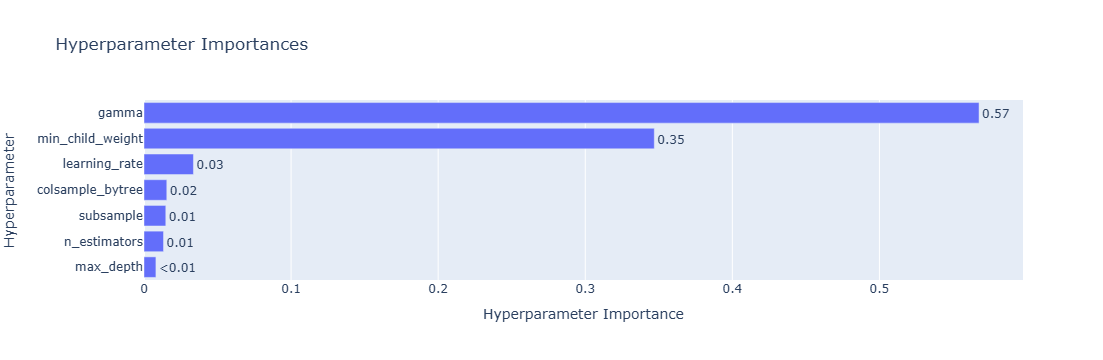

In [22]:
optuna.visualization.plot_param_importances(study).show()